<a href="https://colab.research.google.com/github/AIWintermuteAI/Seeed_Arduino_Sketchbook/blob/master/examples/WioTerminal_TinyML_4_Weather_Prediction/weather_prediction_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TinyML with Wio Terminal Course 4: Weather prediction 
by Dmitry Maslov
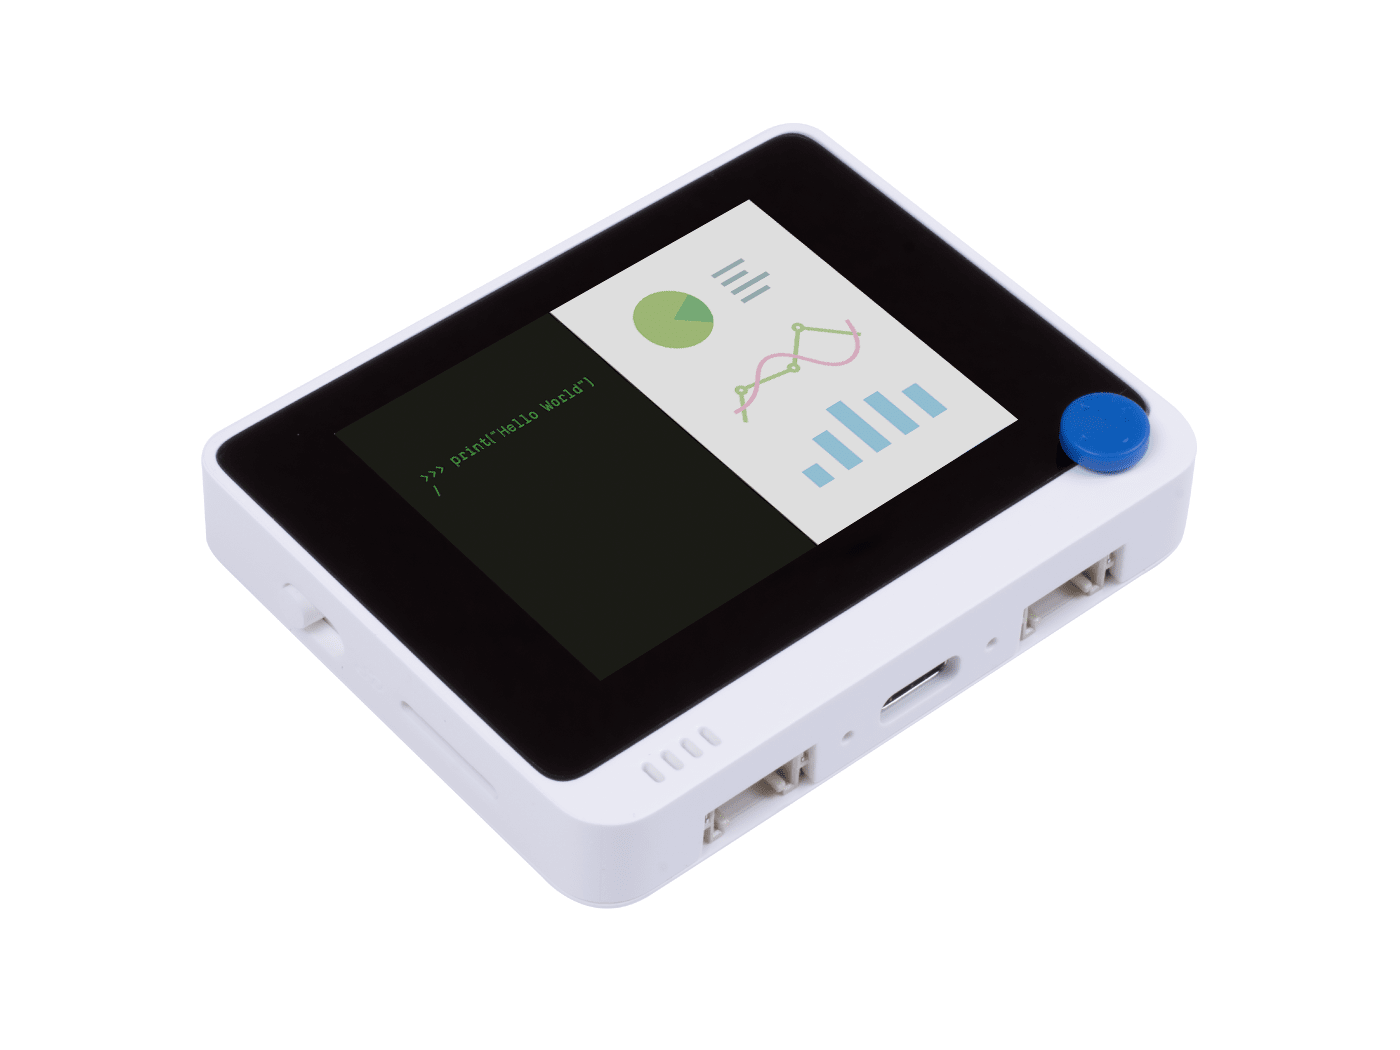

Link to the video:
https://youtu.be/qbpVltzvL6Q

Link to the article:


We start by downloading the dataset from Kaggle - you will need to create (or log into) Kaggle account and create API token. To do that, click on your profile pic -> Account, scroll down a bit and you'll see Create New API token button.
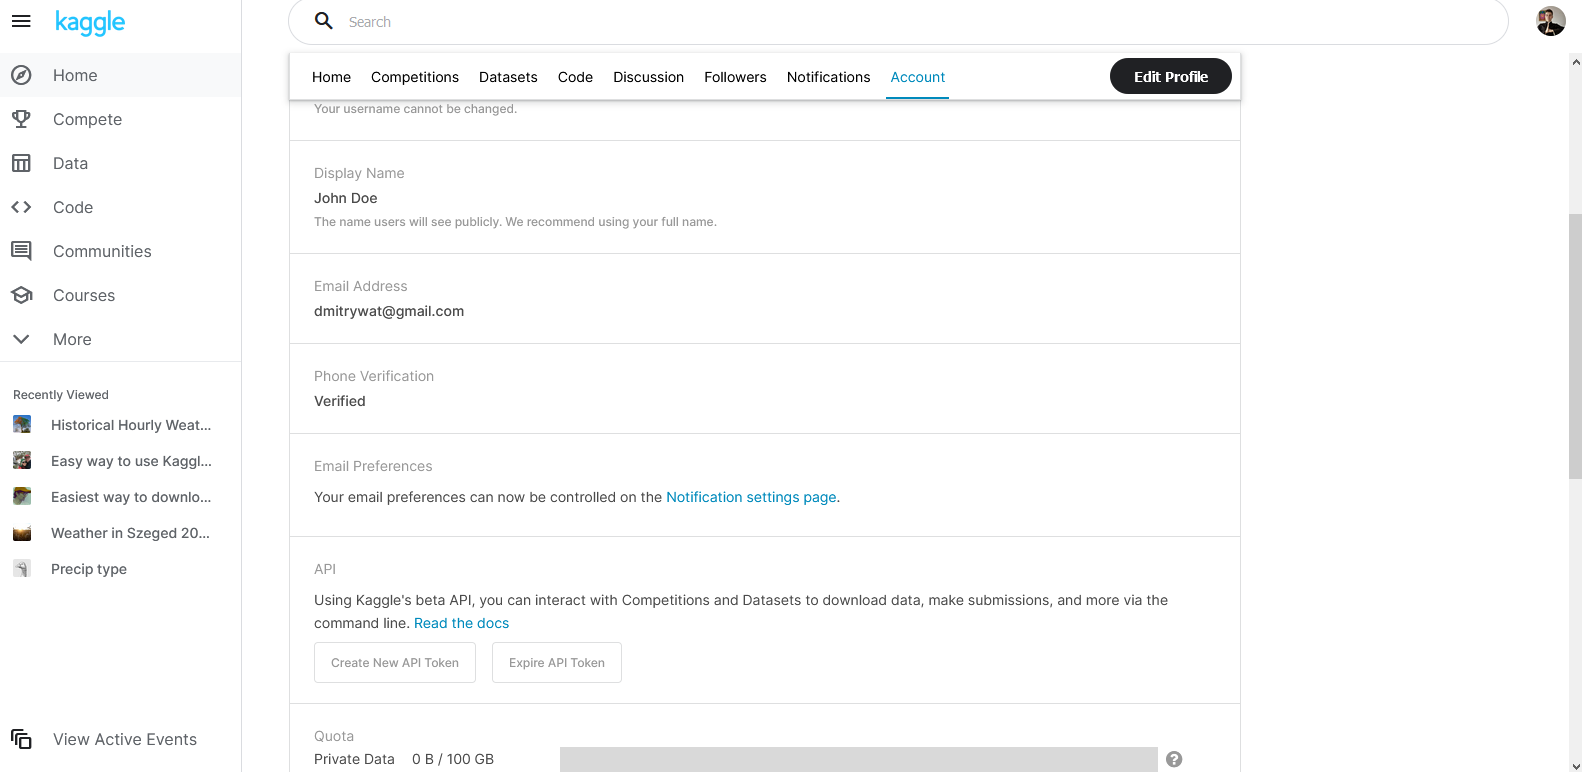
Download the JSON file and place it in Google Drive Kaggle folder.


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Kaggle"
!kaggle datasets download -d selfishgene/historical-hourly-weather-data

historical-hourly-weather-data.zip: Skipping, found more recently modified local copy (use --force to force download)


Unzip it to /content.

In [ ]:
!unzip -qq /content/historical-hourly-weather-data.zip

In the next cell we create a training folder, where we'll put model files later. Now it is time to examine the dataset and do some preliminary cleaning. We use pandas to read csv files, dropping all the columns except for the city we're interested in - in this case it's Miami. 

Then you can notice (or can't - on the first time training the model I missed this fact), that dataset has different number of rows for different weather conditions. In other words, for example for Miami, there are more data points in the end of the .csv file for temperature, than there is for humidity. The most complete column is weather description. It's bad, but not horrible, since our data measurements were taken just one hour apart, we can "inpaint" the holes.

In [ ]:
import pandas as pd
import os
from datetime import datetime

window_size = 24
epochs = 200
batch_size = 128

train_date = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
root_path = os.path.join('/content/drive/MyDrive/projects/weather/', train_date)
if not os.path.isdir(root_path): os.makedirs(root_path)

df_temp = pd.read_csv('temperature.csv', usecols = ['Miami'])
df_temp = df_temp - 273.15
df_humid = pd.read_csv('humidity.csv', usecols = ['Miami'])
df_pres = pd.read_csv('pressure.csv', usecols = ['Miami'])
df_desc = pd.read_csv('weather_description.csv', usecols = ['Miami'])

df_list = [df_temp, df_humid, df_pres, df_desc]
missing_rows = []

for df in df_list: 
  print(df.isnull().values.sum())

for df in df_list: 
  df.drop(df.tail(793).index, inplace=True)
  df.drop(df.head(1).index, inplace=True)
  df.reset_index(inplace = True, drop = True)
  print(df)
  print("Indexes of nan values:", list(df.loc[pd.isna(df["Miami"]), :].index))

805
1087
794
793
           Miami
0      26.570000
1      26.582518
2      26.616579
3      26.650641
4      26.684703
...          ...
44454  27.000000
44455  26.770000
44456  26.660000
44457  26.000000
44458  25.750000

[44459 rows x 1 columns]
Indexes of nan values: [3858, 3859, 6917, 6918, 6946, 6947, 7253, 7509, 7510, 9888, 9889, 9890]
       Miami
0       83.0
1       82.0
2       82.0
3       82.0
4       81.0
...      ...
44454   54.0
44455   54.0
44456   54.0
44457   61.0
44458   54.0

[44459 rows x 1 columns]
Indexes of nan values: [916, 920, 935, 936, 937, 938, 939, 941, 968, 969, 983, 984, 985, 986, 998, 1013, 1014, 1016, 1022, 1023, 1034, 1035, 1036, 1037, 1060, 1061, 1062, 1063, 1069, 1070, 1071, 1076, 1084, 1085, 1203, 1281, 1282, 1302, 1303, 1304, 1328, 1350, 1375, 1376, 1420, 1422, 1425, 1430, 1563, 1606, 1642, 1736, 1737, 1738, 1739, 1926, 1991, 2008, 2014, 2015, 2049, 2081, 2091, 2092, 2248, 2266, 2338, 2553, 2704, 2719, 2899, 3050, 3372, 3438, 3439, 3440, 3441, 3449

Here we use Pandas built-in interpolate function, which performs linear interpolation at missing data points. You can read more about it here

https://pandas.pydata.org/pandas-docs/stable/user_guide/missing_data.html

After interpolation, all the missing values are gone.

In [ ]:
for df in df_list[:3]: 
  df.interpolate(inplace=True)
  print(df)
  print(list(df.loc[pd.isna(df["Miami"]), :].index))

           Miami
0      26.570000
1      26.582518
2      26.616579
3      26.650641
4      26.684703
...          ...
44454  27.000000
44455  26.770000
44456  26.660000
44457  26.000000
44458  25.750000

[44459 rows x 1 columns]
[]
       Miami
0       83.0
1       82.0
2       82.0
3       82.0
4       81.0
...      ...
44454   54.0
44455   54.0
44456   54.0
44457   61.0
44458   54.0

[44459 rows x 1 columns]
[]
        Miami
0      1011.0
1      1011.0
2      1011.0
3      1011.0
4      1011.0
...       ...
44454  1015.0
44455  1015.0
44456  1015.0
44457  1014.0
44458  1014.0

[44459 rows x 1 columns]
[]


After examining the dataset, we see that weather description column has 25 different labels - way above our TinyML model pay grade. We need to simplify it down to 4 basic weather types: cloudy, sunny, foggy and rainy. The replace function will print out the strings, that are absent from the dictionary. If you're using a different dataset, you will need to change the dictionary values.

In [ ]:
labels = df_desc.Miami.unique()
print(labels)

weather_types = {'cloudy':['broken clouds', 'overcast clouds', 'scattered clouds', 'few clouds'],
                 'rainy':['light intensity drizzle', 'light rain', 'moderate rain', 'thunderstorm with heavy rain', 'heavy intensity rain',
                          'proximity thunderstorm', 'thunderstorm with light rain', 'thunderstorm', 'squalls', 'thunderstorm with rain', 'very heavy rain', 'proximity shower rain',
                          'drizzle', 'light intensity shower rain', 'shower rain', 'tornado'],
                 'sunny':['sky is clear'],
                 'foggy':['mist', 'haze', 'fog', 'smoke']}

def replace(content):
  for weather_type in weather_types.keys():
    for weather in weather_types[weather_type]:
      if content == weather:      
        return weather_type
  print(content)

df_desc['Miami'] = df_desc['Miami'].map(replace)  

print(df_desc)

labels = df_desc.Miami.unique()
print(labels)

['light intensity drizzle' 'broken clouds' 'mist' 'overcast clouds'
 'light rain' 'moderate rain' 'thunderstorm with heavy rain'
 'heavy intensity rain' 'sky is clear' 'haze' 'few clouds'
 'scattered clouds' 'proximity thunderstorm'
 'thunderstorm with light rain' 'fog' 'thunderstorm' 'squalls' 'smoke'
 'thunderstorm with rain' 'very heavy rain' 'proximity shower rain'
 'drizzle' 'light intensity shower rain' 'shower rain' 'tornado']
        Miami
0       rainy
1      cloudy
2      cloudy
3      cloudy
4      cloudy
...       ...
44454  cloudy
44455  cloudy
44456  cloudy
44457  cloudy
44458  cloudy

[44459 rows x 1 columns]
['rainy' 'cloudy' 'foggy' 'sunny']


Next, we concatenate the four data frames into one. We skip the last window_size number of rows from input data dataframes, because we don't have weather description for them. For weather description dataframe we take the rows starting with window size index. So the data we get after concatenation is 

0_hour_temperature 0_hour_humidity 0_hour_pressure 25th_hour_description

In [ ]:
frames = [df_temp[:-window_size], df_humid[:-window_size], df_pres[:-window_size], df_desc[window_size:].reset_index(drop = True)]
df = pd.concat(frames, axis=1)
df.columns = ['temp', 'humid', 'pres', 'type']

print("First 50 rows: ", df[0:50])
print("Last 50 rows: ", df[-50:])

print(df['temp'].isnull().sum())
print(df['humid'].isnull().sum())
print(df['pres'].isnull().sum())
print(df['type'].isnull().sum())

First 50 rows:           temp  humid    pres    type
0   26.570000   83.0  1011.0  cloudy
1   26.582518   82.0  1011.0   foggy
2   26.616579   82.0  1011.0  cloudy
3   26.650641   82.0  1011.0   rainy
4   26.684703   81.0  1011.0   rainy
5   26.718765   81.0  1011.0   rainy
6   26.752827   81.0  1011.0   rainy
7   26.786888   80.0  1011.0   foggy
8   26.820950   80.0  1011.0   rainy
9   26.855012   79.0  1011.0   rainy
10  26.889074   79.0  1011.0   foggy
11  26.923135   79.0  1011.0   rainy
12  26.957197   78.0  1011.0   rainy
13  26.991259   78.0  1011.0   foggy
14  27.025321   78.0  1011.0   rainy
15  27.059382   77.0  1011.0  cloudy
16  27.093444   77.0  1011.0  cloudy
17  27.127506   76.0  1011.0  cloudy
18  27.161568   76.0  1011.0   foggy
19  27.195629   76.0  1011.0   sunny
20  27.229691   75.0  1011.0   rainy
21  27.263753   75.0  1011.0   rainy
22  27.297815   75.0  1011.0   foggy
23  27.331876   74.0  1011.0   sunny
24  27.365938   74.0  1011.0  cloudy
25  27.400000   74.0  

Now, simplifying weather types into four basic groups has a distinct disadvantage of loosing some of information - for example there is a huge difference between 

light rain

and 

thunderstorm with heavy rain

Perhaps we could somehow alleviate the problem, by adding another type of data, precipitation, which we can calculate by dividing number occurrences of rainy weather by total number of data points in the time window. Let's say we had 2 rainy hours within 24 hour window, then precipitation will be set to 0.083 or 8.3 percent. If we had a long rain however (say, 12 hours of rain within 24 hours), the precipitation will reflect that - the value we'll get in this case is 50%.

In [ ]:
df_test = df[:100]
df_test.insert(4, "precip", None, True) 

for index, row in df_test.iterrows():
  if index == len(df_test) - window_size:
    break
  print(index)  
  print(df_test.loc[index:index+window_size-1, ('type')])
  value = df_test.loc[index:index+window_size-1, ('type')].isin(['rainy']).sum(axis=0)/window_size
  df_test['precip'][index] = value

print(df_test[:])

0
0     cloudy
1      foggy
2     cloudy
3      rainy
4      rainy
5      rainy
6      rainy
7      foggy
8      rainy
9      rainy
10     foggy
11     rainy
12     rainy
13     foggy
14     rainy
15    cloudy
16    cloudy
17    cloudy
18     foggy
19     sunny
20     rainy
21     rainy
22     foggy
23     sunny
Name: type, dtype: object
1
1      foggy
2     cloudy
3      rainy
4      rainy
5      rainy
6      rainy
7      foggy
8      rainy
9      rainy
10     foggy
11     rainy
12     rainy
13     foggy
14     rainy
15    cloudy
16    cloudy
17    cloudy
18     foggy
19     sunny
20     rainy
21     rainy
22     foggy
23     sunny
24    cloudy
Name: type, dtype: object
2
2     cloudy
3      rainy
4      rainy
5      rainy
6      rainy
7      foggy
8      rainy
9      rainy
10     foggy
11     rainy
12     rainy
13     foggy
14     rainy
15    cloudy
16    cloudy
17    cloudy
18     foggy
19     sunny
20     rainy
21     rainy
22     foggy
23     sunny
24    cloudy
25    cloudy
Name: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


In the last cell we just tested the precipitation calculation, now we apply it to the whole dataset.

In [ ]:
df.insert(4, "precip", None, True) 

for index, row in df.iterrows():
  if index == len(df) - window_size:
    break
  value = df.loc[index:index+window_size-1, ('type')].isin(['rainy']).sum(axis=0)/window_size
  df['precip'][index] = value

print("First 50 rows: ", df[0:50])
print("Last 50 rows: ", df[-50:])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


First 50 rows:           temp  humid    pres    type    precip
0   26.570000   83.0  1011.0  cloudy  0.458333
1   26.582518   82.0  1011.0   foggy  0.458333
2   26.616579   82.0  1011.0  cloudy  0.458333
3   26.650641   82.0  1011.0   rainy  0.458333
4   26.684703   81.0  1011.0   rainy  0.416667
5   26.718765   81.0  1011.0   rainy     0.375
6   26.752827   81.0  1011.0   rainy     0.375
7   26.786888   80.0  1011.0   foggy     0.375
8   26.820950   80.0  1011.0   rainy  0.416667
9   26.855012   79.0  1011.0   rainy     0.375
10  26.889074   79.0  1011.0   foggy  0.333333
11  26.923135   79.0  1011.0   rainy     0.375
12  26.957197   78.0  1011.0   rainy     0.375
13  26.991259   78.0  1011.0   foggy  0.333333
14  27.025321   78.0  1011.0   rainy  0.333333
15  27.059382   77.0  1011.0  cloudy  0.291667
16  27.093444   77.0  1011.0  cloudy  0.333333
17  27.127506   76.0  1011.0  cloudy     0.375
18  27.161568   76.0  1011.0   foggy  0.416667
19  27.195629   76.0  1011.0   sunny  0.4583

Next, we re-arrange the data in weather description column - to get the weather description for the whole window_size period we find the value that has most occurrences in the time window and set cell value to it. For example if following the first cell within 24 hour period we have 20 cloudy hours, 1 rainy and 3 foggy, we would set the value for this cell to cloudy. Then repeat the same procedure for every cell in type column. After transformation our data looks like this:

0_hour_temperature 0_hour_humidity 0_hour_pressure 25-49th_hour_average_type 25-49th_hour_precipitaion_percentage


In [ ]:
for index, row in df.iterrows():
  if index == len(df) - window_size:
    break
  value = df.loc[index:index+window_size-1, ('type')].value_counts().idxmax()
  df['type'][index] = value

labels = df.type.unique()

print(labels)
print("First 50 rows: \n", df[0:50])
print("Last 50 rows: \n", df[-50:])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


['rainy' 'cloudy' 'foggy' 'sunny']
First 50 rows: 
          temp  humid    pres    type    precip
0   26.570000   83.0  1011.0   rainy  0.458333
1   26.582518   82.0  1011.0   rainy  0.458333
2   26.616579   82.0  1011.0   rainy  0.458333
3   26.650641   82.0  1011.0   rainy  0.458333
4   26.684703   81.0  1011.0   rainy  0.416667
5   26.718765   81.0  1011.0   rainy     0.375
6   26.752827   81.0  1011.0   rainy     0.375
7   26.786888   80.0  1011.0   rainy     0.375
8   26.820950   80.0  1011.0   rainy  0.416667
9   26.855012   79.0  1011.0   rainy     0.375
10  26.889074   79.0  1011.0  cloudy  0.333333
11  26.923135   79.0  1011.0   rainy     0.375
12  26.957197   78.0  1011.0   rainy     0.375
13  26.991259   78.0  1011.0  cloudy  0.333333
14  27.025321   78.0  1011.0  cloudy  0.333333
15  27.059382   77.0  1011.0  cloudy  0.291667
16  27.093444   77.0  1011.0  cloudy  0.333333
17  27.127506   76.0  1011.0  cloudy     0.375
18  27.161568   76.0  1011.0   rainy  0.416667
19  27.1

We have a big problem however, which will be painfully obvious when you start the training. That problem is heavy class imbalance: we can see that cloudy is the dominant class, with ~30000 samples, which dwarfs the other classes. In this case even if you model predicts cloudy for every data sample, it will still get ~70 percent accuracy. 

The problem is less pronouced with precipitation column, since it is not categorical(we will present it as regression and not classifiation problem).

In [ ]:
top_types = df['type'].value_counts()
top_precip = df['precip'].value_counts()

print(top_types)
print(top_precip)
      
multipliers = dict(top_types)

for i in multipliers.keys():
  multipliers[i] = int(top_types[0] / multipliers[i]) - 1

print(multipliers)

cloudy    30515
rainy      7989
sunny      5266
foggy       665
Name: type, dtype: int64
0.000000    13744
0.041667     3588
0.083333     2768
0.125000     2532
0.250000     2487
0.208333     2349
0.166667     2300
0.416667     1771
0.291667     1769
0.333333     1599
0.375000     1542
0.541667     1307
0.458333     1167
1.000000     1111
0.500000      881
0.583333      476
0.916667      445
0.625000      394
0.666667      372
0.750000      346
0.791667      330
0.958333      329
0.708333      289
0.875000      260
0.833333      255
Name: precip, dtype: int64
{'cloudy': 0, 'rainy': 2, 'sunny': 4, 'foggy': 44}


In the next cell we convert categorical type column to one-hot.

In [ ]:
# Get one hot encoding of columns B
one_hot = pd.get_dummies(df['type'])
# Drop column B as it is now encoded
df = df.drop('type', axis = 1)
df = df.join(one_hot)

print(df)
labels = list(df.columns)[4:] 
print(labels)

            temp  humid    pres    precip  cloudy  foggy  rainy  sunny
0      26.570000   83.0  1011.0  0.458333       0      0      1      0
1      26.582518   82.0  1011.0  0.458333       0      0      1      0
2      26.616579   82.0  1011.0  0.458333       0      0      1      0
3      26.650641   82.0  1011.0  0.458333       0      0      1      0
4      26.684703   81.0  1011.0  0.416667       0      0      1      0
...          ...    ...     ...       ...     ...    ...    ...    ...
44430  23.890000   36.0  1016.0      None       1      0      0      0
44431  24.490000   38.0  1015.0      None       1      0      0      0
44432  24.370000   41.0  1015.0      None       1      0      0      0
44433  24.250000   50.0  1015.0      None       1      0      0      0
44434  23.670000   47.0  1015.0      None       1      0      0      0

[44435 rows x 8 columns]
['cloudy', 'foggy', 'rainy', 'sunny']


Finally, we get ready the data to be fed in the neural network:

- Convert the data to numpy array
- Normalize the data. Here the temperature was divided by 60 (the hottest weather, according to Wikipedia), humidity by 100, since it is a percentage and pressure by 1000 (gives us number close to 1).

We create a numpy array with zeros shape of (length of dataframe - window_size, window_size*3) and then populate it with values from first three columns.

We then split the data and keep the proportions between classes for test dataset.

After the split we apply RandomOversampling, which resamples the minority classes to the number of majority class by randomly choosing samples and returning the corresponding indexes. We then use these indexes to match precipitation values, which were left behind during oversampling (RandomOverSampler can only use categorical values).

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

oversampling = True 

data_array = df.to_numpy().astype('float32')

data_array[:, 0] /= 60
data_array[:, 1] /= 100
data_array[:, 2] /= 1000

X = np.zeros(shape = (data_array[:, 3].shape[0]-window_size, window_size*3))

for i in range(len(data_array)-window_size):
  X[i] = data_array[i:i+window_size, 0:3].flatten()

y_precip = data_array[:-window_size, 3]
y_type = data_array[:-window_size, 4:]

y = data_array[:-window_size, 3:]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=0, stratify=y_type)

y_precip_temp = y_train[:, 0]
y_type_train = y_train[:, 1:]

y_precip_test= y_test[:, 0]
y_type_test = y_test[:, 1:]

if oversampling:
  from imblearn.over_sampling import SMOTE, RandomOverSampler
  # define oversampling strategy
  oversampler = RandomOverSampler(return_indices=True)
  # fit and apply the transform
  ros = oversampler.fit(X_train, y_type_train)
  res = ros.fit_resample(X_train, y_type_train)
  X_train = res[0]
  y_type_train = res[1]
  y_precip_train = np.zeros(shape = (res[2].shape[0], 1))
  for i in range(len(y_precip_train)):
    y_precip_train[i] = y_precip_temp[res[2][i]]

X_train = np.reshape(X_train, (-1, window_size, 3))
X_test = np.reshape(X_test, (-1, window_size, 3))

print("Train set shapes: ", X_train.shape, y_type_train.shape, y_precip_train.shape)
print("Last training window X: \n", X_train[-window_size:])
print("Last training window type: \n", y_type_train[-window_size:])
print("Last training window precipitation: \n", y_precip_train[-window_size:])

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Train set shapes:  (120760, 24, 3) (120760, 4) (120760, 1)
Last training window X: 
 [[[0.38433889 0.81       1.03299999]
  [0.36413333 0.86000001 1.03299999]
  [0.36888331 0.81999999 1.03299999]
  ...
  [0.44451109 0.52999997 1.028     ]
  [0.41531667 0.63999999 1.02900004]
  [0.40236667 0.62       1.028     ]]

 [[0.51203889 0.77999997 1.03199995]
  [0.50356114 0.81       1.03199995]
  [0.501975   0.87       1.03199995]
  ...
  [0.48333332 0.74000001 1.02100003]
  [0.49071825 0.75999999 1.02400005]
  [0.48552075 0.80000001 1.02400005]]

 [[0.377875   0.81999999 1.03400004]
  [0.37193888 0.82999998 1.03400004]
  [0.3710278  0.82999998 1.03400004]
  ...
  [0.39703333 0.75999999 1.03299999]
  [0.40445    0.74000001 1.03299999]
  [0.39986667 0.75       1.03299999]]

 ...

 [[0.3915     0.69       1.01900005]
  [0.39050001 0.69       1.01900005]
  [0.3865     0.69       1.01900005]
  ...
  [0.40799999 0.64999998 1.01800001]
  [0.39733332 0.64999998 1.01800001]
  [0.39283332 0.61000001 1.0

Finally we randomly choose ten samples for manual sanity check.

In [ ]:
for i in range(10):
  num = np.random.randint(0, len(X_train))
  print("Sample", num)
  print(X_train[num])
  print("Actual class: ", labels[np.argmax(y_type_train[num])])
  print("Actual precipitation: ", y_precip_train[num])
  print("------")

Sample 35811
[[0.42916667 0.77999997 1.01600003]
 [0.43333334 0.82999998 1.01600003]
 [0.43733332 0.77999997 1.01600003]
 [0.454      0.74000001 1.01699996]
 [0.45616668 0.74000001 1.01800001]
 [0.46683332 0.74000001 1.01800001]
 [0.49033335 0.69999999 1.01800001]
 [0.49416667 0.66000003 1.01800001]
 [0.48116669 0.74000001 1.01800001]
 [0.48483333 0.66000003 1.01800001]
 [0.48666668 0.79000002 1.01699996]
 [0.48133332 0.69999999 1.01699996]
 [0.47483334 0.74000001 1.01699996]
 [0.46833333 0.79000002 1.01699996]
 [0.46283334 0.79000002 1.01800001]
 [0.45349997 0.79000002 1.01800001]
 [0.45716667 0.88       1.01900005]
 [0.45733336 0.82999998 1.01900005]
 [0.45616668 0.94       1.01900005]
 [0.45616668 0.88       1.01900005]
 [0.45616668 0.82999998 1.01800001]
 [0.454      0.82999998 1.01800001]
 [0.44999999 0.94       1.01800001]
 [0.45633331 0.94       1.01900005]]
Actual class:  cloudy
Actual precipitation:  [0.04166667]
------
Sample 32233
[[0.45783332 0.69       1.01999998]
 [0.4524

In the following four cells, four different architectures are tested for 200 epochs with Reduce Learning Rate on Plateau and Model Checkpoint callbacks.

The architectures we test are:
- plain Conv1D with Average Pooling
- SeparableConv1D with Average Pooling
- SeparableConv1D with dilation for first three layers
- Fully connected network with roughly the same number of parameters as plain Conv1D with Average Pooling

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dropout, Dense, Conv1D, AveragePooling1D, Input, Flatten, SeparableConv1D

keras.backend.clear_session()

input = Input(shape=(window_size, 3, ))
x = Conv1D(8, 3, activation='relu', padding='same')(input)
x = AveragePooling1D(2)(x)
x = Conv1D(16, 3, activation='relu', padding='same')(x)
x = AveragePooling1D(2)(x)
x = Conv1D(32, 3, activation='relu', padding='same')(x)
x = AveragePooling1D(2)(x)
x = Conv1D(32, 3, activation='relu', padding='same')(x)
x = Conv1D(64, 3, activation='relu', padding='same')(x)
#x = GlobalAveragePooling1D()(x)
x = Dropout(0.25)(x)
x = Flatten()(x)
type_out = Dense(len(labels), activation="softmax", name="type")(x)
precip_out = Dense(1, activation="sigmoid", name="precip")(x)

model = keras.Model(inputs=input, outputs=[type_out, precip_out], name="weather_model")

model.summary()

optim = tf.optimizers.Adam(lr=1e-3)

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_type_accuracy', mode='max', factor=0.1, patience=20, min_lr=1e-6, verbose=1)
checkpoint_filepath = os.path.join(root_path, 'model_Conv1D.h5')
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_type_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

model.compile(loss = {'type': 'categorical_crossentropy', 'precip': 'mean_squared_error'}, 
              optimizer = optim, metrics = {'type': 'accuracy', 'precip': None})

model.fit(X_train, [y_type_train, y_precip_train], validation_data=(X_test, [y_type_test, y_precip_test]), epochs=200, batch_size=batch_size, shuffle=True, callbacks=[reduce_lr, model_checkpoint])

Model: "weather_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 24, 3)]      0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 24, 8)        80          input_1[0][0]                    
__________________________________________________________________________________________________
average_pooling1d (AveragePooli (None, 12, 8)        0           conv1d[0][0]                     
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 12, 16)       400         average_pooling1d[0][0]          
______________________________________________________________________________________

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dropout, Dense, Conv1D, AveragePooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D, Input, Reshape, Flatten

keras.backend.clear_session()

input = Input(shape=(window_size,3, ))
x = SeparableConv1D(8, 3, activation='relu', padding='same')(input)
x = AveragePooling1D(2)(x)
x = SeparableConv1D(16, 3, activation='relu', padding='same')(x)
x = AveragePooling1D(2)(x)
x = SeparableConv1D(32, 3, activation='relu', padding='same')(x)
x = AveragePooling1D(2)(x)
x = SeparableConv1D(32, 3, activation='relu', padding='same')(x)
x = SeparableConv1D(64, 3, activation='relu', padding='same')(x)
#x = GlobalAveragePooling1D()(x)
x = Dropout(0.1)(x)
x = Flatten()(x)
type_out = Dense(len(labels), activation="softmax", name="type")(x)
precip_out = Dense(1, activation="sigmoid", name="precip")(x)

model = keras.Model(inputs=input, outputs=[type_out, precip_out], name="weather_model")

model.summary()

optim = tf.optimizers.Adam(lr=1e-3)

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_type_accuracy', mode='max', factor=0.1, patience=20, min_lr=1e-6, verbose=1)
checkpoint_filepath = os.path.join(root_path, 'model_SeparableConv1D.h5')
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_type_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

model.compile(loss = {'type': 'categorical_crossentropy', 'precip': 'mean_squared_error'}, 
              optimizer = optim, metrics = {'type': 'accuracy', 'precip': None})

model.fit(X_train, [y_type_train, y_precip_train], validation_data=(X_test, [y_type_test, y_precip_test]), epochs=epochs, batch_size=batch_size, shuffle=True, callbacks=[reduce_lr, model_checkpoint])

Model: "weather_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 24, 3)]      0                                            
__________________________________________________________________________________________________
separable_conv1d (SeparableConv (None, 24, 8)        41          input_1[0][0]                    
__________________________________________________________________________________________________
average_pooling1d (AveragePooli (None, 12, 8)        0           separable_conv1d[0][0]           
__________________________________________________________________________________________________
separable_conv1d_1 (SeparableCo (None, 12, 16)       168         average_pooling1d[0][0]          
______________________________________________________________________________________

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dropout, Dense, Conv1D, AveragePooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D, Input, Reshape, Flatten

keras.backend.clear_session()

input = Input(shape=(window_size,3, ))
x = SeparableConv1D(8, 3, activation='relu', padding='same', dilation_rate=2)(input)
x = SeparableConv1D(16, 2, activation='relu', padding='same', dilation_rate=2)(x)
x = SeparableConv1D(32, 2, activation='relu', padding='same', dilation_rate=2)(x)
x = SeparableConv1D(32, 3, activation='relu', padding='same')(x)
x = SeparableConv1D(64, 3, activation='relu', padding='same')(x)
#x = GlobalAveragePooling1D()(x)
x = Dropout(0.25)(x)
x = Flatten()(x)
type_out = Dense(len(labels), activation="softmax", name="type")(x)
precip_out = Dense(1, activation="sigmoid", name="precip")(x)

model = keras.Model(inputs=input, outputs=[type_out, precip_out], name="weather_model")

model.summary()

optim = tf.optimizers.Adam(lr=1e-3)

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_type_accuracy', mode='max', factor=0.1, patience=20, min_lr=1e-6, verbose=1)
checkpoint_filepath = os.path.join(root_path, 'model_SeparableDilatedConv1D.h5')
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_type_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

model.compile(loss = {'type': 'categorical_crossentropy', 'precip': 'mean_squared_error'}, 
              optimizer = optim, metrics = {'type': 'accuracy', 'precip': None})

model.fit(X_train, [y_type_train, y_precip_train], validation_data=(X_test, [y_type_test, y_precip_test]), epochs=epochs, batch_size=batch_size, shuffle=True, callbacks=[reduce_lr, model_checkpoint])

Model: "weather_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 24, 3)]      0                                            
__________________________________________________________________________________________________
separable_conv1d (SeparableConv (None, 24, 8)        41          input_1[0][0]                    
__________________________________________________________________________________________________
separable_conv1d_1 (SeparableCo (None, 24, 16)       160         separable_conv1d[0][0]           
__________________________________________________________________________________________________
separable_conv1d_2 (SeparableCo (None, 24, 32)       576         separable_conv1d_1[0][0]         
______________________________________________________________________________________

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dropout, Dense, Conv1D, AveragePooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D, Input, Reshape, Flatten

keras.backend.clear_session()

input = Input(shape=(window_size,3, ))
x = Reshape(target_shape=(window_size*3,))(input)
x = Dense(128, activation="relu")(x)
x = Dropout(0.25)(x)
x = Dense(32, activation="relu")(x)
type_out = Dense(len(labels), activation="softmax", name="type")(x)
precip_out = Dense(1, activation="sigmoid", name="precip")(x)

model = keras.Model(inputs=input, outputs=[type_out, precip_out], name="weather_model")

model.summary()

optim = tf.optimizers.Adam(lr=1e-3)

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_type_accuracy', mode='max', factor=0.1, patience=20, min_lr=1e-6, verbose=1)
checkpoint_filepath = os.path.join(root_path, 'model_FC.h5')
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_type_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

model.compile(loss = {'type': 'categorical_crossentropy', 'precip': 'mean_squared_error'}, 
              optimizer = optim, metrics = {'type': 'accuracy', 'precip': None})

model.fit(X_train, [y_type_train, y_precip_train], validation_data=(X_test, [y_type_test, y_precip_test]), epochs=epochs, batch_size=128, shuffle=True, callbacks=[reduce_lr, model_checkpoint])

Model: "weather_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 24, 3)]      0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 72)           0           input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          9344        reshape[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128)          0           dense[0][0]                      
______________________________________________________________________________________

After all training is done we can compare the performance of the models using confusion matrix and inference on random samples from test dataset.

model_Conv1D.h5
[[242   1  30  32]
 [  0   6   1   0]
 [ 16   0  61   3]
 [  5   0   1  47]]


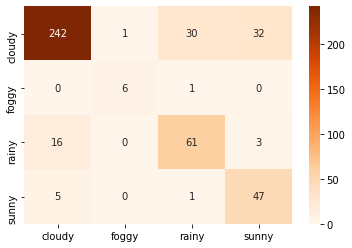

Sample 208
[[0.49399999 0.74000001 1.01800001]
 [0.49083334 0.82999998 1.01800001]
 [0.48483333 0.79000002 1.01900005]
 [0.48500001 0.79000002 1.01900005]
 [0.48500001 0.79000002 1.01900005]
 [0.48316666 0.82999998 1.01800001]
 [0.48500001 0.82999998 1.01800001]
 [0.48400003 0.79000002 1.01800001]
 [0.48400003 0.82999998 1.01800001]
 [0.47266668 0.94       1.01800001]
 [0.46799999 0.77999997 1.01699996]
 [0.45366666 0.88       1.01800001]
 [0.45750001 0.88       1.01800001]
 [0.47816667 0.82999998 1.01800001]
 [0.50683331 0.79000002 1.01800001]
 [0.51483333 0.69999999 1.01800001]
 [0.50483334 0.77999997 1.01800001]
 [0.49833333 0.74000001 1.01800001]
 [0.50683331 0.74000001 1.01699996]
 [0.52100003 0.69999999 1.01699996]
 [0.52233332 0.69999999 1.01600003]
 [0.51483333 0.69999999 1.01600003]
 [0.50611907 0.70999998 1.01600003]
 [0.47849998 0.77999997 1.01699996]]
Predicted class:  cloudy
Actual class:  cloudy
Predicted precipitation:  [[0.26358423]]
Actual precipitation:  0.375
------


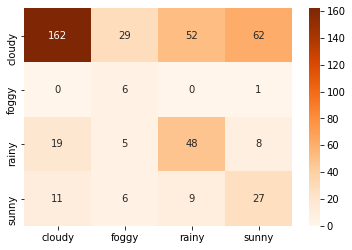

Sample 327
[[0.5243333  0.66000003 1.01800001]
 [0.49149999 0.88       1.01800001]
 [0.49566665 0.77999997 1.01699996]
 [0.48816669 0.77999997 1.01800001]
 [0.48516667 0.69       1.01800001]
 [0.47800002 0.74000001 1.01699996]
 [0.47349998 0.74000001 1.01800001]
 [0.47383335 0.77999997 1.01800001]
 [0.47333333 0.74000001 1.01900005]
 [0.46183333 0.77999997 1.01900005]
 [0.45583335 0.77999997 1.01900005]
 [0.45116666 0.82999998 1.01900005]
 [0.44633335 0.82999998 1.01900005]
 [0.43983331 0.82999998 1.01800001]
 [0.42500001 0.88       1.01800001]
 [0.42500001 0.88       1.01800001]
 [0.42466667 0.82999998 1.01800001]
 [0.414      0.82999998 1.01800001]
 [0.43800002 0.77999997 1.01900005]
 [0.46733335 0.66000003 1.01900005]
 [0.50099999 0.66000003 1.01900005]
 [0.52383333 0.62       1.01900005]
 [0.53733337 0.55000001 1.01900005]
 [0.54366666 0.49000001 1.01900005]]
Predicted class:  cloudy
Actual class:  cloudy
Predicted precipitation:  [[0.21016465]]
Actual precipitation:  0.20833333
--

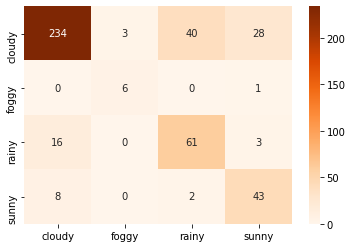

Sample 101
[[0.33761111 0.80000001 1.03499997]
 [0.38222221 0.72000003 1.03600001]
 [0.37003332 0.74000001 1.03499997]
 [0.43357781 0.63       1.03600001]
 [0.44032222 0.62       1.03600001]
 [0.43491665 0.62       1.03499997]
 [0.44571111 0.60000002 1.03499997]
 [0.44435555 0.58999997 1.03400004]
 [0.41297498 0.69       1.03499997]
 [0.42162779 0.64999998 1.03400004]
 [0.40025556 0.70999998 1.03400004]
 [0.39160833 0.75999999 1.03499997]
 [0.36599445 0.82999998 1.03499997]
 [0.35310555 0.88       1.03499997]
 [0.353625   0.85000002 1.03499997]
 [0.33626667 0.93000001 1.03600001]
 [0.33231667 0.93000001 1.03600001]
 [0.33038333 0.92000002 1.03499997]
 [0.32576111 0.92000002 1.03499997]
 [0.32315555 0.92000002 1.03499997]
 [0.32223332 0.92000002 1.03499997]
 [0.31906664 0.91000003 1.03499997]
 [0.31758335 0.91000003 1.03499997]
 [0.37522501 0.82999998 1.03499997]]
Predicted class:  sunny
Actual class:  sunny
Predicted precipitation:  [[0.22780353]]
Actual precipitation:  0.25
------
Sam

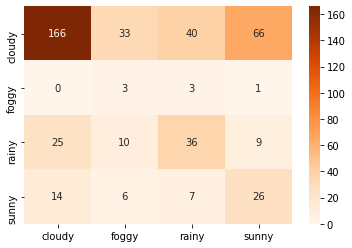

Sample 244
[[0.32016665 0.88       1.01600003]
 [0.31383333 0.93000001 1.01499999]
 [0.30583334 0.93000001 1.01499999]
 [0.30316669 0.93000001 1.01499999]
 [0.30366665 0.88       1.01600003]
 [0.32416669 0.82999998 1.01499999]
 [0.37816668 0.73000002 1.01600003]
 [0.41916665 0.69       1.01600003]
 [0.44316667 0.64999998 1.01600003]
 [0.45733336 0.56999999 1.01499999]
 [0.45983332 0.61000001 1.01400006]
 [0.45133334 0.64999998 1.01300001]
 [0.44399998 0.69       1.01300001]
 [0.45283332 0.61000001 1.01300001]
 [0.44116667 0.56999999 1.01400006]
 [0.42550001 0.61000001 1.01400006]
 [0.40166667 0.69       1.01499999]
 [0.39200002 0.77999997 1.01499999]
 [0.37833336 0.77999997 1.01499999]
 [0.36499998 0.88       1.01600003]
 [0.35016668 0.88       1.01600003]
 [0.34200001 0.88       1.01499999]
 [0.33583334 0.88       1.01400006]
 [0.3256667  0.88       1.01400006]]
Predicted class:  sunny
Actual class:  cloudy
Predicted precipitation:  [[0.19037457]]
Actual precipitation:  0.0
------
Sam

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import tensorflow.keras as keras
import matplotlib.pyplot as plt

#root_path = '/content/drive/MyDrive/projects/weather/2021-03-11_03-00-43'
filenames = ['model_Conv1D.h5', 'model_SeparableConv1D.h5', 'model_SeparableDilatedConv1D.h5', 'model_FC.h5']

for model_filename in filenames:
  checkpoint_filepath = os.path.join(root_path, model_filename)
  model = keras.models.load_model(checkpoint_filepath)
  pred = model.predict(X_test)
  y_type_categorical = np.argmax(y_type_test, axis = 1)
  pred_categorical = np.argmax(pred[0], axis = 1)
  confm = confusion_matrix(y_type_categorical, pred_categorical, labels=None)
  print(model_filename)
  print(confm)
  df_cm = pd.DataFrame(confm, index=labels, columns=labels)
  ax = sn.heatmap(df_cm, cmap='Oranges', annot=True, fmt='d')
  plt.show()

  for i in range(10):
    num = np.random.randint(0, len(X_test))
    print("Sample", num)
    print(X_test[num])
    pred = model.predict(np.expand_dims(X_test[num], axis=0))
    print("Predicted class: ", labels[np.argmax(pred[0])])
    print("Actual class: ", labels[np.argmax(y_type_test[num])])
    print("Predicted precipitation: ", pred[1])
    print("Actual precipitation: ", y_precip_test[num])
    print("------")

Then we convert the best model (which you manually choose according to test results in the previous cell) to Tensorflow Lite INT8 quantized model and save it to the training folder.

In [ ]:
import tensorflow as tf

def representative_dataset():
    for i in range(100):
      data = np.expand_dims(X_test[i], axis=0)
      yield [data.astype(np.float32)]

root_path = "/content/drive/MyDrive/projects/weather/2021-03-16_08-54-12"
model_filename = 'model_SeparableDilatedConv1D.h5'
checkpoint_filepath = os.path.join(root_path, model_filename)
model = keras.models.load_model(checkpoint_filepath)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_type = tf.int8
converter.inference_input_type = tf.int8 
converter.inference_output_type = tf.int8
tflite_quant_model = converter.convert()

# Save the model.
tflite_filename = checkpoint_filepath.split('.')[0] + '.tflite'
with open(tflite_filename, 'wb') as f:
  f.write(tflite_quant_model)

INFO:tensorflow:Assets written to: /tmp/tmpsd61s9q0/assets


A good idea after conversion is check if model inference results are still correct after quantization (some accuracy loss is expected however).

In [ ]:
interpreter = tf.lite.Interpreter(model_path = tflite_filename)
interpreter.allocate_tensors()

input_scale, input_zero_point = interpreter.get_tensor_details()[0]["quantization"]
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

for i in range(10):
  num = np.random.randint(0, len(X_test))

  input_data = np.asarray(X_test[num], dtype=np.float32)
  input_data_int8 =  np.asarray(input_data/input_scale + input_zero_point, dtype=np.int8)

  interpreter.set_tensor(input_details[0]['index'], np.expand_dims(input_data_int8, axis=0))
  interpreter.invoke()

  output_data_precip = np.asarray(interpreter.get_tensor(output_details[0]['index']), dtype=np.float32)
  output_data_type = np.asarray(interpreter.get_tensor(output_details[1]['index']), dtype=np.float32)
  print(output_data_precip, output_data_type)

  precip = (output_data_precip - input_zero_point) * input_scale
  weather_type = (output_data_type - input_zero_point) * input_scale

  print(precip, weather_type)
  print("Sample", num)
  print(str(repr(input_data.flatten())).replace("[", "{").replace("]", "}"))
  print("Predicted class: ", labels[np.argmax(weather_type[0])])
  print("Actual class: ", labels[np.argmax(y_type_test[num])])
  print("Predicted precipitation: ", precip[0][0])
  print("Actual precipitation: ", y_precip_test[num])
  print("------")

[[-100.]] [[ 119. -128. -119. -128.]]
[[0.11408627]] [[1.0064039  0.         0.03667059 0.        ]]
Sample 356
array({0.442     , 0.57      , 1.021     , 0.43716666, 0.65      ,
       1.02      , 0.43083334, 0.57      , 1.02      , 0.422     ,
       0.65      , 1.02      , 0.402     , 0.65      , 1.02      ,
       0.39733332, 0.73      , 1.021     , 0.39916667, 0.73      ,
       1.021     , 0.39583334, 0.69      , 1.021     , 0.39566666,
       0.69      , 1.021     , 0.3905    , 0.73      , 1.021     ,
       0.39266667, 0.73      , 1.02      , 0.388     , 0.69      ,
       1.02      , 0.37916666, 0.73      , 1.019     , 0.37150002,
       0.78      , 1.019     , 0.36483333, 0.73      , 1.019     ,
       0.36466664, 0.73      , 1.019     , 0.34933332, 0.78      ,
       1.019     , 0.3465    , 0.78      , 1.02      , 0.38233334,
       0.69      , 1.02      , 0.4045    , 0.61      , 1.021     ,
       0.435     , 0.57      , 1.021     , 0.43166667, 0.54      ,
       1.02      

In the final cell of this notebook we write the content of .tflite file as a bytearray to a .h file to be later compiled with our sketch in Arduino IDE. You will be able to download the model from your Google Drive.

In [ ]:
tfmicro_filename = checkpoint_filepath.split('.')[0] + '.h'
!apt-get install -y xxd
!xxd -i $tflite_filename > $tfmicro_filename

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  xxd
0 upgraded, 1 newly installed, 0 to remove and 29 not upgraded.
Need to get 49.3 kB of archives.
After this operation, 200 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 xxd amd64 2:8.0.1453-1ubuntu1.4 [49.3 kB]
Fetched 49.3 kB in 0s (978 kB/s)
Selecting previously unselected package xxd.
(Reading database ... 160975 files and directories currently installed.)
Preparing to unpack .../xxd_2%3a8.0.1453-1ubuntu1.4_amd64.deb ...
Unpacking xxd (2:8.0.1453-1ubuntu1.4) ...
Setting up xxd (2:8.0.1453-1ubuntu1.4) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
